In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set seed for reproducibility
np.random.seed(42)

In [ ]:
def generate_custom_data(samples_per_class=300):
    # Defining centers manually
    centers = [
        [0, 0],
        [4, 4],
        [-4, 4],
        [-4, -4],
        [4, -4]
    ]

    data = []
    labels = []

    for class_id, center in enumerate(centers):
        # Generate random noise around the center
        noise = np.random.randn(samples_per_class, 2) * 1.0
        points = noise + np.array(center)

        data.append(points)
        labels.append(np.full(samples_per_class, class_id))

    # Stack into a single matrix
    X = np.vstack(data)
    y = np.hstack(labels)

    # Shuffle manually
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    return X[indices], y[indices]

# Generate the raw data
X_raw, y_raw = generate_custom_data()
print(f"Dataset Shape: {X_raw.shape}")

Dataset Shape: (1500, 2)


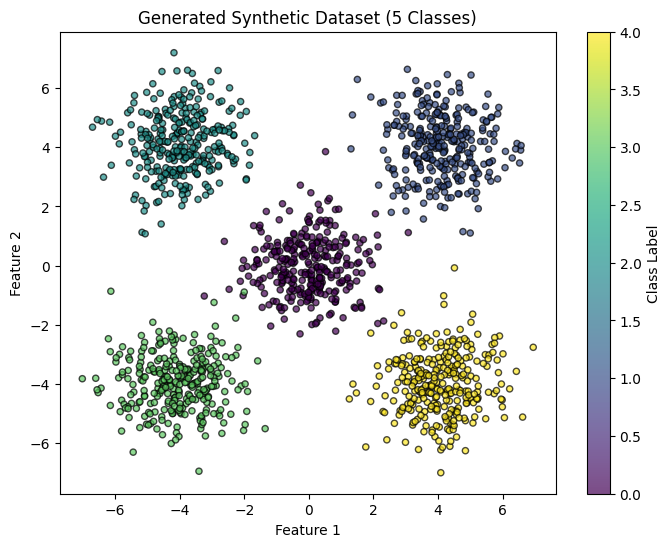

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y_raw, cmap='viridis', edgecolor='k', s=20, alpha=0.7)
plt.title("Generated Synthetic Dataset (5 Classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class Label")
plt.show()

In [ ]:
# Manual Train/Test Split (80% Train, 20% Test)
total_samples = X_raw.shape[0]
split_index = int(0.8 * total_samples)

X_train_raw = X_raw[:split_index]
y_train = y_raw[:split_index]

X_test_raw = X_raw[split_index:]
y_test = y_raw[split_index:]

# Standardization (Z-Score Normalization)
train_mean = np.mean(X_train_raw, axis=0)
train_std = np.std(X_train_raw, axis=0) + 1e-8  # epsilon for stability

X_train = (X_train_raw - train_mean) / train_std
X_test = (X_test_raw - train_mean) / train_std

# One-Hot Encoding Helper
def one_hot_encode(y, num_classes=5):
    m = len(y)
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot

y_train_enc = one_hot_encode(y_train)
y_test_enc = one_hot_encode(y_test)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (1200, 2)
Testing Data: (300, 2)


In [ ]:
class RowMajorNetwork:
    def __init__(self, input_size, hidden_layers, output_size, learning_rate=0.01):
        self.lr = learning_rate

        h1, h2, h3 = hidden_layers

        self.w1 = np.random.randn(input_size, h1) * np.sqrt(2/input_size)
        self.b1 = np.zeros((1, h1))

        self.w2 = np.random.randn(h1, h2) * np.sqrt(2/h1)
        self.b2 = np.zeros((1, h2))

        self.w3 = np.random.randn(h2, h3) * np.sqrt(2/h2)
        self.b3 = np.zeros((1, h3))

        self.w4 = np.random.randn(h3, output_size) * np.sqrt(2/h3)
        self.b4 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def d_relu(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        Z_shifted = Z - np.max(Z, axis=1, keepdims=True)
        exp_Z = np.exp(Z_shifted)
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward(self, X):
        # Layer 1
        self.z1 = X @ self.w1 + self.b1
        self.a1 = self.relu(self.z1)

        # Layer 2
        self.z2 = self.a1 @ self.w2 + self.b2
        self.a2 = self.relu(self.z2)

        # Layer 3
        self.z3 = self.a2 @ self.w3 + self.b3
        self.a3 = self.relu(self.z3)

        # Output
        self.z4 = self.a3 @ self.w4 + self.b4
        self.probs = self.softmax(self.z4)
        return self.probs

    def compute_loss(self, y_true_enc, y_pred):
        # Categorical Cross Entropy
        m = y_true_enc.shape[0]
        epsilon = 1e-15
        loss = -np.sum(y_true_enc * np.log(y_pred + epsilon)) / m
        return loss

    def backward_step(self, X, y_true_enc):
        m = X.shape[0]

        # Output Gradient
        delta4 = self.probs - y_true_enc
        dw4 = (self.a3.T @ delta4) / m
        db4 = np.sum(delta4, axis=0, keepdims=True) / m

        # Layer 3 Gradient
        delta3 = (delta4 @ self.w4.T) * self.d_relu(self.z3)
        dw3 = (self.a2.T @ delta3) / m
        db3 = np.sum(delta3, axis=0, keepdims=True) / m

        # Layer 2 Gradient
        delta2 = (delta3 @ self.w3.T) * self.d_relu(self.z2)
        dw2 = (self.a1.T @ delta2) / m
        db2 = np.sum(delta2, axis=0, keepdims=True) / m

        # Layer 1 Gradient
        delta1 = (delta2 @ self.w2.T) * self.d_relu(self.z1)
        dw1 = (X.T @ delta1) / m
        db1 = np.sum(delta1, axis=0, keepdims=True) / m

        # Update Parameters
        self.w1 -= self.lr * dw1
        self.b1 -= self.lr * db1
        self.w2 -= self.lr * dw2
        self.b2 -= self.lr * db2
        self.w3 -= self.lr * dw3
        self.b3 -= self.lr * db3
        self.w4 -= self.lr * dw4
        self.b4 -= self.lr * db4

In [ ]:
# Initialize Model
model = RowMajorNetwork(input_size=2, hidden_layers=[24, 24, 12], output_size=5, learning_rate=0.1)

epochs = 1500
loss_history = []

print("Training started...")
for i in range(epochs):
    # Forward
    predictions = model.forward(X_train)

    # Loss
    loss = model.compute_loss(y_train_enc, predictions)
    loss_history.append(loss)

    # Backward
    model.backward_step(X_train, y_train_enc)

    if i % 200 == 0:
        print(f"Epoch {i}: Loss {loss:.4f}")

print("Training Complete.")

Training started...
Epoch 0: Loss 1.8844
Epoch 200: Loss 0.0309
Epoch 400: Loss 0.0151
Epoch 600: Loss 0.0117
Epoch 800: Loss 0.0102
Epoch 1000: Loss 0.0093
Epoch 1200: Loss 0.0087
Epoch 1400: Loss 0.0081
Training Complete.


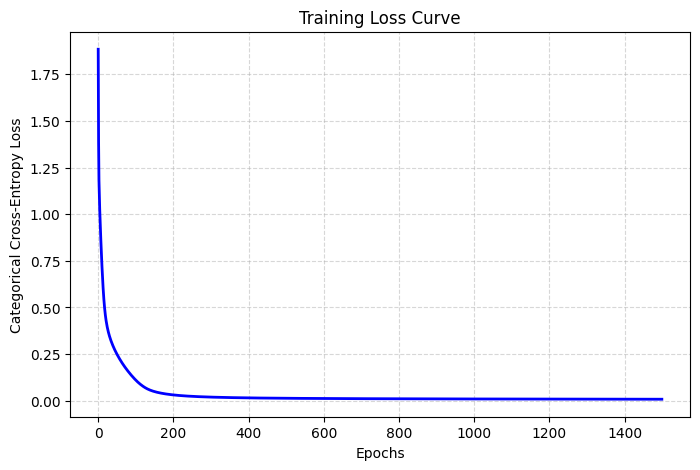

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, color='blue', linewidth=2)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Predict on Test Set
test_probs = model.forward(X_test)
test_preds = np.argmax(test_probs, axis=1)

# Generate Report
print("Classification Report:")
print(classification_report(y_test, test_preds))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        73
           3       1.00      1.00      1.00        54
           4       0.98      1.00      0.99        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



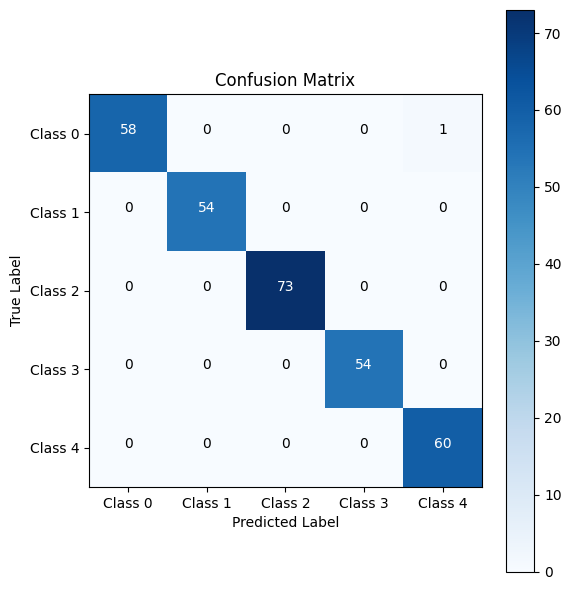

In [ ]:
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(5)
plt.xticks(tick_marks, [f"Class {i}" for i in range(5)])
plt.yticks(tick_marks, [f"Class {i}" for i in range(5)])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

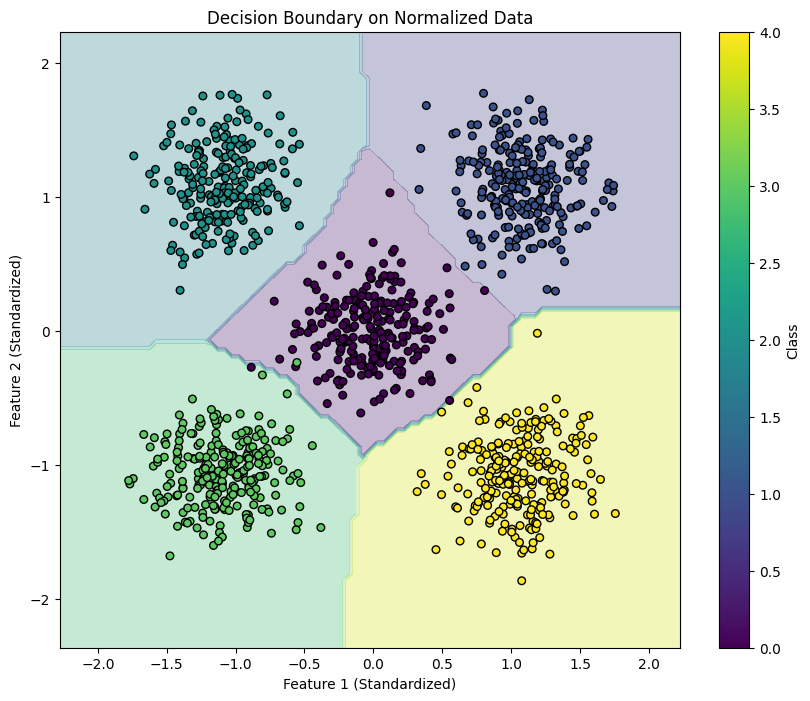

In [ ]:
plt.figure(figsize=(10, 8))

x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5

h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]

Z = model.forward(grid_points)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

# Contour plot
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Scatter plot
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=30)

plt.title("Decision Boundary on Normalized Data")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.colorbar(scatter, label="Class")
plt.show()

# Multi-Class Classification with a 3-Hidden Layer Neural Network

## 1. Introduction
In this assignment, we implemented a deep neural network from scratch using **NumPy** to solve a multi-class classification problem. The primary objective was to extend a basic neural network architecture to include **three hidden layers** and handle **five distinct classes**. The implementation involves custom forward and backward propagation algorithms without the use of high-level frameworks like TensorFlow or PyTorch.

## 2. Dataset Generation
To train the model, we generated a synthetic dataset representing a **"5-Die Pattern"**.
* **Generation:** instead of random blobs, we defined 5 specific center coordinates (Center, Top-Left, Top-Right, Bottom-Left, Bottom-Right) and generated Gaussian noise around them. This creates a challenging yet structured dataset.
* **Preprocessing:**
    * **Splitting:** The data was shuffled and split into 80% Training and 20% Testing sets.
    * **Normalization:** We applied **Z-Score Standardization** $((X - \mu) / \sigma)$ using statistics from the training set to ensure the neural network converges efficiently.
    * **Encoding:** Target labels were converted to **One-Hot Vectors** to match the output layer format.

## 3. Architecture & Code Modifications
The neural network class was significantly modified to support multi-class classification:
* **Network Structure:** Input Layer (2 Features) $\rightarrow$ 3 Hidden Layers (ReLU) $\rightarrow$ Output Layer (5 Neurons).
* **Activation Functions:**
    * **Hidden Layers:** Used **ReLU** (Rectified Linear Unit) to prevent vanishing gradients in the deeper network.
    * **Output Layer:** Implemented **Softmax** activation to output a probability distribution across the 5 classes.
* **Loss Function:** Replaced binary loss with **Categorical Cross-Entropy Loss** to correctly punish misclassifications in a multi-class setting.
* **Initialization:** Implemented **He Initialization** (scaling weights by $\sqrt{2/n_{in}}$) to ensure stability when using ReLU activations.

## 4. Training and Testing
* **Training Configuration:** The model was trained for **1500 epochs** with a learning rate of **0.1**.
* **Optimization:** We used standard Batch Gradient Descent. In every epoch, the model computed the gradients for all layers using the chain rule (Backpropagation) and updated the weights and biases.

## 5. Results and Analysis
The code outputs three key visualizations to analyze performance:
1.  **Loss Curve:** Shows the Categorical Cross-Entropy decreasing over epochs, indicating the network is successfully learning.
2.  **Confusion Matrix:** A heatmap displaying the correspondence between True and Predicted classes. Diagonal elements represent correct predictions.
3.  **Decision Boundary:** A contour plot visualizing the regions of the 2D feature space assigned to each class. This confirms the network has learned non-linear boundaries to separate the clusters.

## 6. Conclusion
The implementation successfully demonstrates that a 3-hidden layer neural network can solve non-linear multi-class classification tasks. Key insights include the importance of **Standardization** for convergence and **He Initialization** for training deep networks with ReLU. The final decision boundaries effectively separate the five classes with high accuracy.